In [55]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd/fangming/CEMBA/scripts/BICCN-Mouse-MOp/fig4')
import importlib


from __init__ import *
from __init__jupyterlab import *
from cocluster_cv_utils import *
from scipy import sparse
import collections
import itertools
import re
import fbpca

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import pickle

# import seaborn as sns 
# import matplotlib.pyplot as plt

In [56]:
def nfoldcv(gxc_hvftrs_sub_g0, gxc_hvftrs_sub_g1, resolutions, k, 
                metas_sub, mods_selected, features_selected, settings,   
                ps, drop_npcs,
                cross_mod_distance_measure, knn, relaxation, n_cca,
                npc,
                output_pcX_all, output_cells_all, output_clst_and_umap,
                reduce_dim=0,
                nfolds=5, n_repeats=5, n_splits=5):
    """
    """
    from sklearn.model_selection import KFold
    # 
    mod = mods_selected[0]
    cell_list = gxc_hvftrs_sub_g0[mod].cell
    U, s, Vt = fbpca.pca(gxc_hvftrs_sub_g0[mod].data.todense().T, k=50)
    pcX = U.dot(np.diag(s))
    
    # train and predict on g1
    res_nclsts = []
    res_mse_mean = {mod: [] for mod in mods_selected} 
    res_mse_se = {mod: [] for mod in mods_selected} 
    res_mse_t_mean = {mod: [] for mod in mods_selected} 
    res_mse_t_se = {mod: [] for mod in mods_selected}
    kl = KFold(n_splits=nfolds)
    
    # test different resolution
    for resolution in resolutions:
        print(resolution, end='')
        
        # n_splits
#         for n_split in np.arange(n_splits):
        # split, cluster, proceed
        
        
        
        res_mse = {}
        res_mse_t = {} 

        # cluster on g0 with different resolutions
        df_clst = CEMBA_clst_utils.clustering_routine(pcX, cell_list, k, 
                                                    seed=1, verbose=True,
                                                    resolution=resolution, metric='euclidean', option='plain', n_trees=10, search_k=-1, num_starts=None)
        
        nclsts = len(df_clst['cluster'].unique())
        res_nclsts.append(nclsts) # record number of clusters
        cells_clst = df_clst['cluster'] # cell -> cluster label look up series
        
        # do it in every modality
        for mod in mods_selected:
            print(mod)
            # set up
            res_mse[mod] = []
            res_mse_t[mod] = []
            
            metadata = metas_sub[mod].copy()
            metadata['cluster_cv'] = df_clst.loc[metadata.index, 'cluster'] 
            gxc_hvftr = gxc_hvftrs_sub_g1[mod]
            
            if settings[mod].mod_category == 'mc':
                assert np.all(metadata.index.values == gxc_hvftr.columns.values)
                features_y = gxc_hvftr.T.values
                if reduce_dim:
                    U, s, Vt = fbpca.pca(features_y, k=reduce_dim)
                    features_y = U.dot(np.diag(s))
            else:
                assert np.all(metadata.index.values == gxc_hvftr.cell)
                features_y = pd.DataFrame(gxc_hvftr.data.T.todense(), 
                                          index=gxc_hvftr.cell, 
                                          columns=gxc_hvftr.gene).values
                if reduce_dim:
                    U, s, Vt = fbpca.pca(features_y, k=reduce_dim)
                    features_y = U.dot(np.diag(s))
                
            ncells = len(metadata)
            
            for i_repeat in range(n_repeats):
                print('.', end='')
                
                # shuffle data
                cells_shuffled_idx = np.random.permutation(np.arange(ncells))
                metadata = metadata.iloc[cells_shuffled_idx, :] 
                metadata['cell_idx'] = np.arange(ncells)
                features_y = features_y[cells_shuffled_idx, :]
                
                
                # split training and test 
                for train_idx, test_idx in kl.split(np.arange(ncells)):
                    ti = time.time()
                    # compute cluster centroids for training cells 
                    metadata_train = metadata.iloc[train_idx]
                    clsts_in_train = np.unique(metadata_train['cluster_cv'].values)
                    clsts_not_in_train = np.unique(metadata['cluster_cv'].values).tolist()
                    y_centroids = np.zeros((len(clsts_in_train), features_y.shape[1]))
                    cluster_to_idx_lookup = {}
                    for count_idx, (clst, df_sub) in enumerate(metadata_train.groupby('cluster_cv')):
                        cells_sub_idx = df_sub['cell_idx'].values
                        y_centroids[count_idx, :] = features_y[cells_sub_idx, :].mean(axis=0)
                        cluster_to_idx_lookup[clst] = count_idx
                        clsts_not_in_train.remove(clst)
                    for clst in clsts_not_in_train:
                        cluster_to_idx_lookup[clst] = -1
                    
                    # compute MSE for test cells
                    cells_j = metadata.index.values[test_idx]
                    clsts_i = cells_clst[cells_j]
                    clsts_i_idx = np.array([cluster_to_idx_lookup[clst] for clst in clsts_i])
                    cond = (clsts_i_idx != -1)  # test if clsts_i in clsts_in_train
                    test_idx, cells_j, clsts_i, clsts_i_idx = test_idx[cond], cells_j[cond], clsts_i[cond], clsts_i_idx[cond]
                    diff = features_y[test_idx, :] - y_centroids[clsts_i_idx, :]
                    mse = (diff**2).sum(axis=1).mean()
                    res_mse[mod].append(mse)
                    
                    # compute MSE for training cells 
                    cells_j = metadata.index.values[train_idx]
                    clsts_i = cells_clst[cells_j]
                    clsts_i_idx = np.array([cluster_to_idx_lookup[clst] for clst in clsts_i])
                    diff = features_y[train_idx, :] - y_centroids[clsts_i_idx, :]
                    mse = (diff*diff).sum(axis=1).mean()
                    res_mse_t[mod].append(mse)
                    
                # end of n-fold training test for 
                # each collect 1 data point
                
            # end of n-repeats for
            # summarize n-repeats into stats
            res_mse[mod] = np.array(res_mse[mod])
            
            res_mse_mean[mod].append(res_mse[mod].mean())
            res_mse_se[mod].append(1.96*res_mse[mod].std()/np.sqrt(nfolds))

            res_mse_t[mod] = np.array(res_mse_t[mod])
            res_mse_t_mean[mod].append(res_mse_t[mod].mean())
            res_mse_t_se[mod].append(1.96*res_mse_t[mod].std()/np.sqrt(nfolds))
            print('')
#             break
        # end of n-modality for 
        
    # end of resolution for
    res_nclsts = np.array(res_nclsts)
    
    for mod in mods_selected:
        res_mse_mean[mod] = np.array(res_mse_mean[mod])
        res_mse_se[mod] = np.array(res_mse_se[mod])
        res_mse_t_mean[mod] = np.array(res_mse_t_mean[mod])
        res_mse_t_se[mod] = np.array(res_mse_t_se[mod])

    return ( 
         res_nclsts,
         res_mse_mean, res_mse_se, 
         res_mse_t_mean, res_mse_t_se,
        )
    

# Configs  

In [57]:
name = 'mop_10x_cells_cv'
outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
output_results = outdir + '/cross_validation_results_{}.pkl'.format(name)
output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)

output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
# SAVE_KNN_MAT = True
# output_knn_mat = outdir + '/knn_{}_{{}}_from_{{}}.npz'.format(name)

In [58]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/organized_neurons_v6'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [59]:
mods_selected = [
#     'snmcseq_gene',
#     'snatac_gene',
#     'smarter_cells',
#     'smarter_nuclei',
    '10x_cells', 
#     '10x_nuclei', 
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_Macosko',
    ]

features_selected = ['10x_cells']
# check features
for features_modality in features_selected:
    assert (features_modality in mods_selected)

# within modality
ps = {'mc': 0.9,
      'atac': 0.1,
      'rna': 0.7,
     }
drop_npcs = {'mc': 0,
      'atac': 0,
      'rna': 0,
     }

# across modality
cross_mod_distance_measure = 'correlation' # cca
knn = 20 
relaxation = 3
n_cca = 30

# PCA
npc = 50

# clustering
k = 30
resolutions = [0.8, 1, 2, 4]
# umap
umap_neighbors = 60
min_dist=min_dist = 0.5

## Read in data 

In [60]:
log = snmcseq_utils.create_logger()
logging.info('*')

07/12/2019 02:55:56 PM *


In [61]:
# gene chrome lookup
chroms = np.arange(1, 20, 1).tolist() + ['X']
chroms = ['chr'+str(chrom) for chrom in chroms]

f = PATH_GENEBODY_ANNOTATION
df_genes = pd.read_csv(f, sep="\t")
gene_set_lookup = (df_genes[df_genes['chr'].isin(chroms)]
                            .groupby('gene_name').first()['chr']
                            .replace('chrX', 'chr20')
                            .apply(lambda x: int(x[3:])%2)
                   )
print(gene_set_lookup.value_counts())
gene_set_lookup.head()

1    27039
0    24632
Name: chr, dtype: int64


gene_name
0610005C13Rik    1
0610006L08Rik    1
0610009B22Rik    1
0610009E02Rik    0
0610009L18Rik    1
Name: chr, dtype: int64

In [62]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

10x_cells (117688, 12)


In [63]:
gxc_hvftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        f_mat = hvftrs_f.format(mod, 'tsv')
        gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
        gxc_hvftrs[mod].index = SCF_utils.standardize_gene_name(gxc_hvftrs[mod].index)  # standardize gene name 
        print(gxc_hvftrs[mod].shape, time.time()-ti)
        assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        continue
        
        
    f_mat = hvftrs_f.format(mod, 'npz')
    f_gene = hvftrs_gene.format(mod)
    f_cell = hvftrs_cell.format(mod)
    _gxc_tmp = snmcseq_utils.load_gc_matrix(f_gene, f_cell, f_mat)
    _gene = _gxc_tmp.gene
    _cell = _gxc_tmp.cell
    _mat = _gxc_tmp.data

    _gene = SCF_utils.standardize_gene_name(_gene)  # standardize gene name  
    
#     ## remove duplicated genes (for now)
#     u, c = np.unique(_gene, return_counts=True)
#     dup = u[c > 1]
#     uniq_bool = np.array([False if gene in dup else True for gene in _gene])
#     _gene_selected = _gene[uniq_bool]
#     _gene_selected_idx = np.arange(len(_gene))[uniq_bool]
#     _gene = _gene_selected
#     _mat = _mat.tocsr()[_gene_selected_idx, :]
#     ## remove duplicated genes complete
    
    gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
    assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
    print(gxc_hvftrs[mod].data.shape, time.time()-ti)
    

10x_cells
(4050, 117688) 15.344202041625977


In [64]:
def subsampling(mods_selected, metas, gxc_hvftrs, p):
    """
    p - fraction of cells from each dataset to be included
    """
    metas_sub = collections.OrderedDict()
    gxc_hvftrs_sub = collections.OrderedDict()
    for mod in mods_selected: 
        # subsample meta
        cells_included = metas[mod].index.values[np.random.rand(len(metas[mod]))<p]
        metas_sub[mod] = metas[mod].loc[cells_included]

        # subsample gxc_hvftrs
        if settings[mod].mod_category == 'mc':
            gxc_hvftrs_sub[mod] = gxc_hvftrs[mod][cells_included]
            print(mod, metas_sub[mod].shape, gxc_hvftrs_sub[mod].shape, time.time()-ti)
            continue

        cells_included_idx = snmcseq_utils.get_index_from_array(gxc_hvftrs[mod].cell, cells_included)
        gxc_hvftrs_sub[mod] = GC_matrix(
                                        gxc_hvftrs[mod].gene,
                                        cells_included,
                                        gxc_hvftrs[mod].data.tocsc()[:, cells_included_idx],
                                        )
        print(mod, metas_sub[mod].shape, gxc_hvftrs_sub[mod].data.shape, time.time()-ti)
    return metas_sub, gxc_hvftrs_sub

In [38]:
# subsample cells
p = 1

if p < 1:
    metas_sub, gxc_hvftrs_sub = subsampling(mods_selected, metas, gxc_hvftrs, p)
else:
    metas_sub = metas
    gxc_hvftrs_sub = gxc_hvftrs

In [39]:
# split features metas_sub, gxc_hvftrs_sub_g0, gxc_hvftrs_sub_g1

gxc_hvftrs_sub_g0 = collections.OrderedDict()
gxc_hvftrs_sub_g1 = collections.OrderedDict()
for mod in mods_selected: 
    # split gxc_hvftrs
    if settings[mod].mod_category == 'mc':
        _genes = gxc_hvftrs_sub[mod].index.values
        _lookup = gene_set_lookup.reindex(_genes).fillna(-1).values
        _genes_set0 = _genes[_lookup == 0]
        _genes_set1 = _genes[_lookup == 1]
        print(len(_genes_set0), len(_genes_set1))
        gxc_hvftrs_sub_g0[mod] = gxc_hvftrs_sub[mod].loc[_genes_set0]
        gxc_hvftrs_sub_g1[mod] = gxc_hvftrs_sub[mod].loc[_genes_set1]
        
        print(mod, gxc_hvftrs_sub_g0[mod].shape, gxc_hvftrs_sub_g1[mod].shape, time.time()-ti)
        continue
        
    _genes = gxc_hvftrs_sub[mod].gene
    _lookup = gene_set_lookup.reindex(_genes).fillna(-1).values
    _genes_set0 = _genes[_lookup == 0]
    _genes_set0_index = snmcseq_utils.get_index_from_array(_genes, _genes_set0)
    _genes_set1 = _genes[_lookup == 1]
    _genes_set1_index = snmcseq_utils.get_index_from_array(_genes, _genes_set1)
    print(len(_genes_set0), len(_genes_set1))
    gxc_hvftrs_sub_g0[mod] = GC_matrix(
                                _genes_set0,
                                gxc_hvftrs_sub[mod].cell,
                                gxc_hvftrs_sub[mod].data.tocsr()[_genes_set0_index,:],
                                )
    gxc_hvftrs_sub_g1[mod] = GC_matrix(
                                _genes_set1,
                                gxc_hvftrs_sub[mod].cell,
                                gxc_hvftrs_sub[mod].data.tocsr()[_genes_set1_index,:],
                                )
    
    print(mod, gxc_hvftrs_sub_g0[mod].data.shape, gxc_hvftrs_sub_g1[mod].data.shape, time.time()-ti)


1716 1996
10x_cells (1716, 117688) (1996, 117688) 16.61879801750183


In [40]:
print(gxc_hvftrs_sub_g0.keys())
print(gxc_hvftrs_sub_g1.keys())

odict_keys(['10x_cells'])
odict_keys(['10x_cells'])


In [41]:
resolutions = [0.5, 1, 2, 3, 4, 6, 8, 12, 16, 20, 30, 40, 60, 80, 100]
(
 res_nclsts, 
 res_mse_mean, res_mse_se, 
 res_mse_t_mean, res_mse_t_se, 
) = nfoldcv(
            gxc_hvftrs_sub_g1, gxc_hvftrs_sub_g0, resolutions, k, 
            metas_sub, mods_selected, features_selected, settings,   
            ps, drop_npcs,
            cross_mod_distance_measure, knn, relaxation, n_cca,
            npc,
            output_pcX_all, output_cells_all, output_clst_and_umap,
            reduce_dim=0,
            nfolds=5, n_repeats=10)

0.5Time used to build kNN map 2.045649528503418
Time used to get kNN 7.099367380142212
Time spent on leiden clustering: 9.862221717834473
10x_cells
..........
1Time used to build kNN map 2.0608315467834473
Time used to get kNN 7.069719076156616
Time spent on leiden clustering: 9.83601689338684
10x_cells
..........
2Time used to build kNN map 2.0605475902557373
Time used to get kNN 7.067620277404785
Time spent on leiden clustering: 9.831213474273682
10x_cells
..........
3Time used to build kNN map 2.044891119003296
Time used to get kNN 7.060274124145508
Time spent on leiden clustering: 9.897838592529297
10x_cells
..........
4Time used to build kNN map 2.0804145336151123
Time used to get kNN 7.039963722229004
Time spent on leiden clustering: 9.875438690185547
10x_cells
..........
6Time used to build kNN map 2.065035343170166
Time used to get kNN 7.034555912017822
Time spent on leiden clustering: 9.856925964355469
10x_cells
..........
8Time used to build kNN map 2.0386765003204346
Time us

In [42]:
# Saving the objects:
with open(output_results, 'wb') as f: 
    pickle.dump((
                 res_nclsts, 
                 res_mse_mean, res_mse_se, 
                 res_mse_t_mean, res_mse_t_se, 
                ), f)

In [48]:
# Getting back the objects:
with open(output_results, 'rb') as f: 
    (res_nclsts, 
     res_mse_mean, res_mse_se, 
     res_mse_t_mean, res_mse_t_se, 
    ) = pickle.load(f)

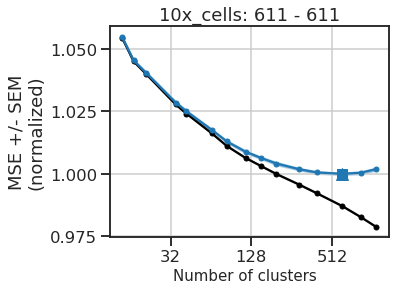

In [54]:
output = output_figures.format('cluster_cv_nosharey', 'pdf')
scale = 1
fig, ax = plt.subplots(1, 1, figsize=(5*scale,4*scale))
base_level = np.min(res_mse_mean[mod])
if i % nx == 0:
    ylabel = 'MSE +/- SEM\n(normalized)'
else:
    ylabel = ''
xlabel = ''
plot_bi_cv_subfig(ax, res_nclsts, 
                  res_mse_mean[mod]/base_level, res_mse_se[mod]/base_level, 
                  res_mse_t_mean[mod]/base_level, res_mse_t_se[mod]/base_level, 
                  settings[mod].color, mod, 
                  xlabel=xlabel,
                  ylabel=ylabel
                 )
ax.yaxis.set_major_locator(mtick.MaxNLocator(4))

fig.subplots_adjust(wspace=0.1, bottom=0.15)
fig.text(0.5, 0, 'Number of clusters', ha='center', fontsize=15)
fig.savefig(output, bbox_inches='tight')
plt.show()